In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Text(0.5, 0, 'Survived')

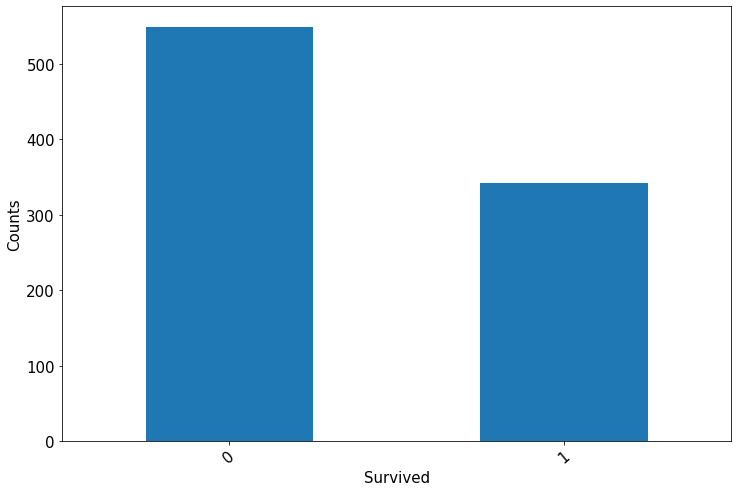

In [11]:
%matplotlib inline
%config InlineBackend.figure_format='png'
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar',
                                                 figsize=(12,8),fontsize=15,rot=40)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)


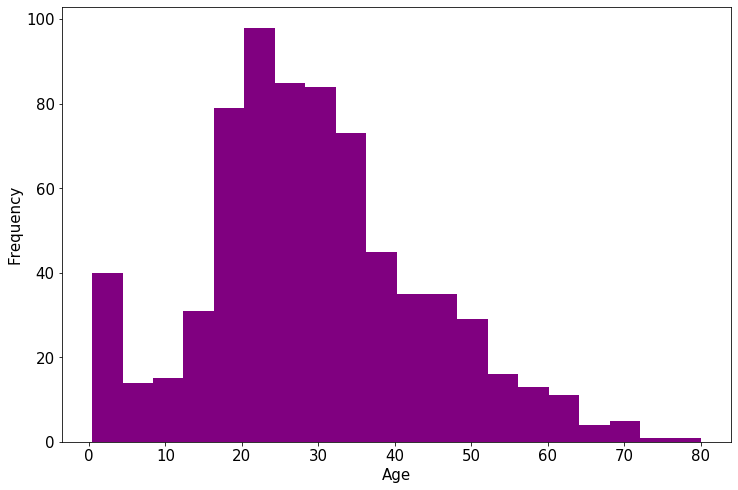

In [14]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind='hist', bins=20, color='purple', figsize=(12,8), fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()

In [ ]:
def preprocessing(dfdata):
    dfresult = pd.DataFrame()
    